https://www.transtats.bts.gov/Fields.asp?Table_ID=236

In [1]:
from __future__ import division #, print_function # Imports from __future__ since we're running Python 2

In [2]:
#%load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [3]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
random_state = 0
%matplotlib inline
plt.style.use('ggplot')
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from datetime import datetime
from sklearn.ensemble import IsolationForest
from helpers.feature_engineering import dateStrToDayYear, getMappingOfSimilarCategoricalColumns, \
    compareSimilarCategoricalColumns 
from helpers.my_one_hot_encoder import MyOneHotEncoder
from helpers.py_helpers import is_number
from scipy.stats import skew, kurtosis
from helpers.outliers import MyOutliers
from sklearn.preprocessing import StandardScaler
from helpers.plot_helper import scatter_2d_label
from sklearn.decomposition import PCA # Import the PCA module
from sklearn.manifold import TSNE
from sklearn.decomposition import KernelPCA
from sklearn.manifold import MDS
from sklearn.dummy import DummyClassifier
from sklearn.manifold import Isomap
from helpers.performance_issues import subsample_keeping_class_proportions
from flights_delay.feature_processing import FlightDelayFeatureProcessing
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from matplotlib.colors import ListedColormap
from flights_delay.flight_delay_scoring import printFlightDelayScores, getFlightDelayScores
from helpers.my_cross_validation import MyCrossValidation
from sklearn.metrics import log_loss
from helpers.performance_issues import processSeparately
from helpers.plot_helper import scatter_2d_label
from flights_delay.flight_delay_scoring import getScore_onKFold_callback

In [4]:
rng = np.random.RandomState(seed=random_state)
#n_jobs = 3 #we prefer to have it run in only a few cores instead of all of them to avoid making the system unstable
n_jobs = 1  #due to memory restrictions

# Flying to New York City - Naive Bayes Classifier

In [5]:
target_col = 'IS_DELAYED'

In [6]:
path_data = os.path.realpath(os.path.join(os.getcwd(), '../Data',
                                          'binary_train_data_numerical_no_outliers_normalized.csv'))
assert os.path.isfile(path_data)
path_data

'/home/student/pligor.george@gmail.com/msc_Artificial_Intelligence/dme_Data_Mining/dmedatarats/Data/binary_train_data_numerical_no_outliers_normalized.csv'

In [7]:
df = pd.read_csv(path_data, header=0)
df.shape

(180133, 533)

In [8]:
df.sample(10, random_state=random_state)

,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_NUM,DEP_TIME,DEP_DELAY,DEP_DELAY_GROUP,DISTANCE,DISTANCE_GROUP,...,DEP_TIME_BLK_9,DEP_TIME_BLK_10,DEP_TIME_BLK_11,DEP_TIME_BLK_12,DEP_TIME_BLK_13,DEP_TIME_BLK_14,DEP_TIME_BLK_15,DEP_TIME_BLK_16,DEP_TIME_BLK_17,IS_DELAYED
165999,0.468116,0.157033,1.162862,-0.966237,0.826288,-1.706637,-0.573752,-0.367736,-1.102857,-0.977812,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
118690,-0.441352,-0.731585,-1.453911,1.574641,-0.126675,-1.473074,-0.293951,-0.367736,-0.415552,-0.253819,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
170863,-1.350820,-1.323998,-0.885047,-1.474413,-0.466086,-0.556195,-0.675497,-0.742084,0.051700,0.108177,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
95968,-1.350820,-1.027791,0.935317,0.050114,1.192461,-1.469214,-0.497442,-0.367736,0.468941,0.470173,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
121221,-0.441352,-0.731585,-0.771274,1.066466,-0.928208,1.611501,-0.726370,-0.742084,-1.124291,-0.977812,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False
151722,-0.441352,-0.435379,-1.681456,1.574641,-0.111662,1.063303,-0.573752,-0.367736,-0.146918,-0.253819,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,False
8018,-1.350820,-1.027791,-1.226365,1.066466,3.753060,1.179120,-0.700934,-0.742084,-0.964253,-0.977812,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,True
30157,-1.350820,-1.620204,0.707771,0.558290,1.831469,1.441637,-0.726370,-0.742084,-1.101428,-0.977812,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,False
59496,-0.441352,-0.435379,-0.088638,1.574641,-0.846619,0.671458,0.494578,0.380961,2.017877,1.918158,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,True
15980,-0.441352,-0.139173,0.252680,1.066466,1.349113,-0.739571,-0.675497,-0.742084,-1.091426,-0.977812,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False


In [9]:
df.info()  #here we are verifying that everything is numerical

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180133 entries, 0 to 180132
Columns: 533 entries, QUARTER to IS_DELAYED
dtypes: bool(1), float64(532)
memory usage: 731.3 MB


In [10]:
XX = df.drop(labels=[target_col], axis=1)
yy = df[target_col]
XX.shape, yy.shape

((180133, 532), (180133,))

In [11]:
del df  #to save memory

In [12]:
columns_not_one_hot = np.array([col for col in XX.columns if not is_number(col[-1])])
columns_not_one_hot

array(['QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'FL_NUM',
       'DEP_TIME', 'DEP_DELAY', 'DEP_DELAY_GROUP', 'DISTANCE',
       'DISTANCE_GROUP', 'YDAY'], 
      dtype='|S15')

In [13]:
XX[columns_not_one_hot].describe()

,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_NUM,DEP_TIME,DEP_DELAY,DEP_DELAY_GROUP,DISTANCE,DISTANCE_GROUP,YDAY
count,1.801330e+05,1.801330e+05,1.801330e+05,1.801330e+05,1.801330e+05,1.801330e+05,1.801330e+05,1.801330e+05,1.801330e+05,1.801330e+05,1.801330e+05
mean,-1.484052e-12,3.126480e-13,1.822616e-13,5.892627e-13,-2.010778e-14,-2.247057e-15,8.564950e-15,-2.171187e-13,1.507782e-13,5.062069e-13,-1.497683e-14
std,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00
min,-1.350820e+00,-1.620204e+00,-1.681456e+00,-1.474413e+00,-1.080291e+00,-2.708448e+00,-1.362280e+00,-1.116432e+00,-1.370063e+00,-1.339808e+00,-1.748677e+00
25%,-4.413519e-01,-7.315854e-01,-8.850472e-01,-9.662371e-01,-7.820001e-01,-8.611779e-01,-6.754973e-01,-7.420838e-01,-7.270543e-01,-6.158155e-01,-8.703420e-01
50%,-4.413519e-01,-1.391733e-01,2.513468e-02,5.011427e-02,-2.526487e-01,6.535273e-02,-4.974424e-01,-3.677355e-01,-1.469179e-01,-2.538192e-01,-1.659459e-03
75%,4.681160e-01,7.494450e-01,8.215438e-01,5.582900e-01,3.341416e-01,8.278103e-01,3.673956e-01,3.809610e-01,4.689412e-01,4.701733e-01,8.380670e-01
max,1.377584e+00,1.638063e+00,1.731726e+00,1.574641e+00,3.774599e+00,1.922275e+00,4.004803e+00,4.124444e+00,2.190775e+00,2.280155e+00,1.774314e+00


### Dummy Classifier

In [14]:
dc = DummyClassifier(random_state=random_state).fit(XX, yy)

In [15]:
dc.score(XX, yy)

0.50231218044444936

In [16]:
dummy_preds = dc.predict(XX)

In [17]:
printFlightDelayScores(y_true=yy, y_pred=dummy_preds)

precision score for delayed flights: 0.485576923077
f1 score for both classes: [ 0.51742959  0.48621698]
f1 score for is_delayed true class: 0.486216975185
f1 score with weighted average: 0.502332107115
f1 score with unweighted average: 0.501823283906


In [18]:
log_loss(y_true = yy, y_pred = dc.predict_proba(XX))

17.18952831409981

### Naive Bayes

In [19]:
cls = GaussianNB()

In [20]:
cls.fit(XX, yy)

GaussianNB(priors=None)

In [21]:
preds = cls.predict(XX)

In [22]:
getFlightDelayScores(y_true=yy, y_pred=preds)

,precision_score,f1_score_nondelayed,f1_score_delayed,f1_score_weighted_avg,f1_score_unweighted_avg
0,0.66099,0.682733,0.707592,0.694757,0.695162


Naive bayes seems to be working better but this might be overfitting. Time for some cross validation

#### cross validation

In [23]:
cv = MyCrossValidation(n_folds=10, random_state=random_state)

In [25]:
df_scores = cv.onEachKFold(XX, yy, getScore_onKFold_callback(cls), take_average=False)

In [26]:
df_scores

,precision_score,f1_score_nondelayed,f1_score_delayed,f1_score_weighted_avg,f1_score_unweighted_avg,log_loss
0,0.661489,0.676595,0.709256,0.692552,0.692925,5.729377
0,0.567335,0.506960,0.683707,0.592547,0.595334,7.566167
0,0.589526,0.576845,0.685913,0.629212,0.631379,6.817545
0,0.650744,0.680548,0.705236,0.692313,0.692892,5.834175
0,0.741181,0.744169,0.696370,0.720990,0.720270,5.675632
0,0.662619,0.679958,0.707470,0.693359,0.693714,5.788213
0,0.766833,0.746901,0.650407,0.700226,0.698654,6.697297
0,0.735736,0.740345,0.701587,0.721475,0.720966,5.591775
0,0.561459,0.498146,0.680120,0.585794,0.589133,7.672527
0,0.594097,0.578282,0.690133,0.632335,0.634208,6.585203


In [27]:
np.mean(df_scores)

precision_score            0.653102
f1_score_nondelayed        0.642875
f1_score_delayed           0.691020
f1_score_weighted_avg      0.666080
f1_score_unweighted_avg    0.666947
log_loss                   6.395791
dtype: float64

So we see that the average f1 score of the Naive Bayes Classifier is around 0.66 for both weighted and unweighted average of the classes scores.

Also log-loss is lower than the dummy classifier which is a good sign that we have achieved something better

There aren't any hyperparameters to tune so this is all we can get with the naive bayes classifier

## process RBF PCA

In [20]:
def getKernelPCA_X(kernel, inputs, gamma=None, n_jobs=n_jobs, n_components = 2):
    return KernelPCA(n_components=n_components, random_state=random_state, kernel=kernel,
                     gamma=gamma, n_jobs=n_jobs).fit_transform(inputs)

In [149]:
def processor(inputs):
    return getKernelPCA_X(kernel='rbf', inputs=inputs, gamma=0.1, n_jobs=1, n_components=2)

In [155]:
df_lowdim = processSeparately(inputs=XX, targets=yy, processor=processor,
                              n_components=2, n_splits=10)
df_lowdim.shape

(18014, 2)
(18014, 1)
(18014, 2)
(18014, 1)
(18014, 2)
(18014, 1)
(18013, 2)
(18013, 1)
(18013, 2)
(18013, 1)
(18013, 2)
(18013, 1)
(18013, 2)
(18013, 1)
(18013, 2)
(18013, 1)
(18013, 2)
(18013, 1)
(18013, 2)
(18013, 1)


(180133, 3)

### Reclassify with unsupervised dimensionality reduction

In [157]:
#tSne = TSNE(n_components=2, perplexity=50, random_state=random_state)
df_lowdim.sample(4)

,component 0,component 1,IS_DELAYED
408,-0.104296,-0.126353,0.0
77525,0.031032,-0.397044,1.0
81483,0.068494,-0.188577,1.0
112794,-0.125536,0.123136,0.0


In [166]:
XX_lowdim = df_lowdim.drop(labels=[target_col], axis=1)
yy_lowdim = df_lowdim[target_col]

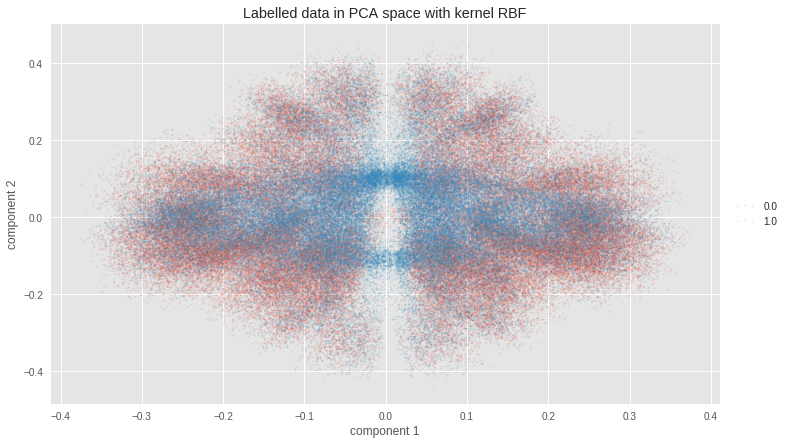

In [163]:
plt.figure(figsize=(12,7))
scatter_2d_label(
    XX_lowdim.values,
    y=yy_lowdim.values, alpha=0.1, s=1, lw=1)
plt.title('Labelled data in PCA space with kernel RBF')
plt.xlabel('component 1')
plt.ylabel('component 2')
# Add a legend outside the plot at specified point
plt.legend(loc='center left', bbox_to_anchor=[1.01, 0.5], scatterpoints=3)
plt.show()

In [167]:
cv = MyCrossValidation(n_folds=10, random_state=random_state)

In [170]:
scores = cv.onEachKFold(XX_lowdim, yy_lowdim, getScore_onKFold_callback(cls))
scores

precision_score            0.610875
f1_score_nondelayed        0.640961
f1_score_delayed           0.583361
f1_score_weighted_avg      0.613100
f1_score_unweighted_avg    0.612161
log_loss                   0.672665
dtype: float64

#### Conclusions
After the dimensionality reduction, the scores have been decreased which is not very encouraging but on the other hand the log_loss has increased a lot as well, meaning that we are much more sure for our predictions

### Repeat for different dim reductions

In [24]:
def rbfPCAkernelAndScore(n_components):
    assert n_components >= 3
    def processor(inputs):
        return getKernelPCA_X(kernel='rbf', inputs=inputs, gamma=0.1, n_jobs=1,
                              n_components=n_components)
    df_lowdim = processSeparately(inputs=XX, targets=yy, processor=processor,
                                  n_components=n_components, n_splits=10)
    XX_lowdim = df_lowdim.drop(labels=[target_col], axis=1)
    yy_lowdim = df_lowdim[target_col]
    cv = MyCrossValidation(n_folds=10, random_state=random_state)
    return cv.onEachKFold(XX_lowdim, yy_lowdim, getScore_onKFold_callback(cls))

In [173]:
rbfPCAkernelAndScore(n_components=3)

precision_score            0.601427
f1_score_nondelayed        0.635484
f1_score_delayed           0.563773
f1_score_weighted_avg      0.600804
f1_score_unweighted_avg    0.599628
log_loss                   0.673236
dtype: float64

In [174]:
rbfPCAkernelAndScore(n_components=4)

precision_score            0.613408
f1_score_nondelayed        0.647943
f1_score_delayed           0.555537
f1_score_weighted_avg      0.603257
f1_score_unweighted_avg    0.601740
log_loss                   0.668552
dtype: float64

In [25]:
rbfPCAkernelAndScore(n_components=5)

precision_score            0.617561
f1_score_nondelayed        0.650844
f1_score_delayed           0.559746
f1_score_weighted_avg      0.606782
f1_score_unweighted_avg    0.605295
log_loss                   0.656796
dtype: float64

#### Conclusions
Bringing more components has decreased the log loss a little bit making our predictions more certain but the f1 scores have not increased. Unfortunately it is not computationally feasible to test larger number of components on our current hardware.

## Plotting probabilities

In [21]:
n_components = 2
def processor(inputs):
    return getKernelPCA_X(kernel='rbf', inputs=inputs, gamma=0.1, n_jobs=1,
                          n_components=n_components)
df_lowdim = processSeparately(inputs=XX, targets=yy, processor=processor,
                              n_components=n_components, n_splits=10)
XX_lowdim = df_lowdim.drop(labels=[target_col], axis=1)
yy_lowdim = df_lowdim[target_col]
cv = MyCrossValidation(n_folds=10, random_state=random_state)

In [24]:
scores = cv.onEachKFold(XX_lowdim, yy_lowdim, getScore_onKFold_callback(cls))
scores

precision_score            0.609911
f1_score_nondelayed        0.640666
f1_score_delayed           0.579456
f1_score_weighted_avg      0.611068
f1_score_unweighted_avg    0.610061
log_loss                   0.672853
accuracy_score             0.612475
dtype: float64

In [25]:
score = scores['accuracy_score']
score

0.61247521658718884

In [40]:
def rendertime(X, y, score, clf,
               h = .02,  # step size in the mesh
               cm = plt.cm.RdBu,
               plot_margin = .2
              ):
    fig = plt.figure(figsize=(12,7))
    ax = plt.subplot(111)
    
    x_min, x_max = X[:, 0].min() - plot_margin, X[:, 0].max() + plot_margin
    y_min, y_max = X[:, 1].min() - plot_margin, X[:, 1].max() + plot_margin
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

    
    scatter_2d_label(
        XX_lowdim.values,
        y=yy_lowdim.values, alpha=0.2, s=1, lw=1, ax= ax)
    
#     ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright) # Plot also the training points
#     ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6) # and testing points

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
#     if ds_cnt == 0:
#         ax.set_title(name)
    
    ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
            size=15, horizontalalignment='right')
    
    plt.show()

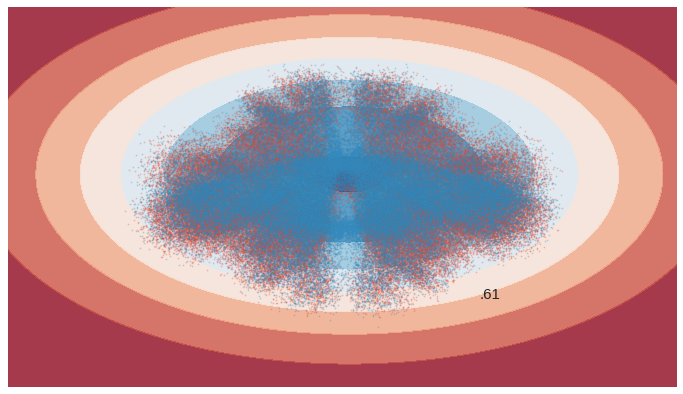

In [41]:
rendertime(X=XX_lowdim.values, y= yy_lowdim.values, score=score, clf=cls)

#### Conclusions
The decision boundaries selected from the gaussian naive bayes model all make sense and the relatively not much higher than the dummy classifier score accuracy of ~61% is expected

### T-SNE dim reduction

In [ ]:
tSne = TSNE(n_components=2, perplexity=30, random_state=random_state)
Xtsne = tSne.fit_transform(Xsubsampled)